# Bayesian Methods Final Project
## Prince Birring & Brent Skoumal
## 04/17/2018

Import Statements and Style Preferences for matplotlib

In [137]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import numpy as np

%matplotlib inline
plt.style.use('ggplot')
sns.set(context="paper", font="monospace")

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Read the data into a pandas dataframe, and inspect the first 5 rows

In [138]:
df = pd.read_csv('https://raw.githubusercontent.com/princebirring/Bayesian-Statistics-for-Data-Science/master/insurance.csv?token=AP_TrSoQpBBqx5XCyutPPLAAr-eXKjiVks5a36ArwA%3D%3D')
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


**sex:** Insurance contractor gender, female, male

**bmi:** Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight using the ratio of height to weight, is between 18.5 to 24.9

**children:** Number of children covered by health insurance / Number of dependents

**smoker:** Smoking

**region:** The beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

**charges:** Individual medical costs billed by health insurance

In [139]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [140]:
print('shape of the dataframe: {}'.format(df.shape))

shape of the dataframe: (1338, 7)


# Transforming Categorical Variables

Looking at the data types above, we have three features that are string objects, we need to convert them to numeric so that we can fit our models

In [141]:
df.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

In [142]:
df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

**"sex"** and **"smoker"** are  binary/nominal, so we will just map() them to "0"/"1"

In [143]:
df['sex'] = df.sex.map({'male':1,'female':0})
df['smoker'] = df.smoker.map({'yes':1,'no':0})

In [144]:
df.region.value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

**"region"** however has 4 values, we will use pandas' "get_dummies()" method to one-hot encode them

In [145]:
df = pd.get_dummies(df)

Now, let's make sure our data is completely numeric, and ready to fit a model

In [146]:
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Feature Importance
Let's figure out which features are important, we will fit a random forest classifier to the data, and extract the "_feature_importances"

In [147]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop('charges',axis=1)
y = df['charges']

clf = RandomForestRegressor(n_estimators=1000)
clf.fit(X,y)

feat_imp = clf.feature_importances_
importances = pd.Series(feat_imp,X.columns)

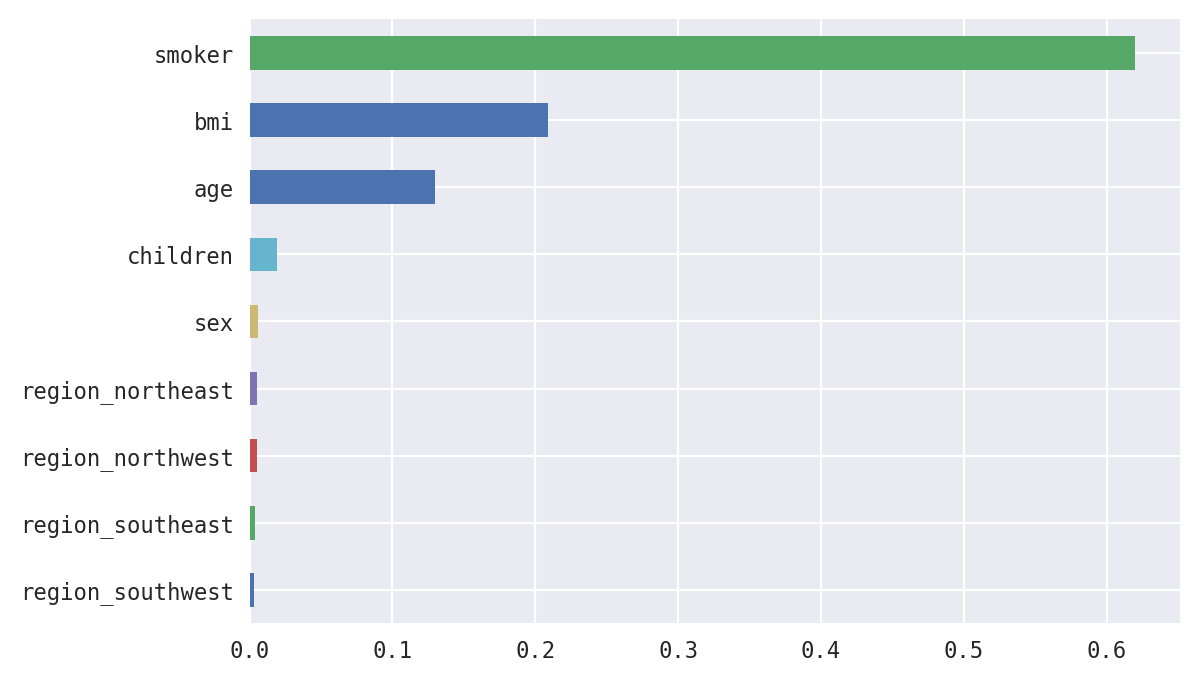

In [148]:
plt.figure(dpi=200)
importances.sort_values().plot.barh()

After investigating which features are important, we noticed that **region** and **sex** appear to be relatively pointless and have very little predictive value, as a result, we will drop them from our dataframe

In [149]:
to_drop = [ 'sex', 'region_northeast', 'region_northwest', 'region_southeast','region_southwest']
df = df.drop(to_drop, axis = 1)

In [150]:
df.head()

,age,bmi,children,smoker,charges
0,19,27.900,0,1,16884.92400
1,18,33.770,1,0,1725.55230
2,28,33.000,3,0,4449.46200
3,33,22.705,0,0,21984.47061
4,32,28.880,0,0,3866.85520


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Feature Correlation

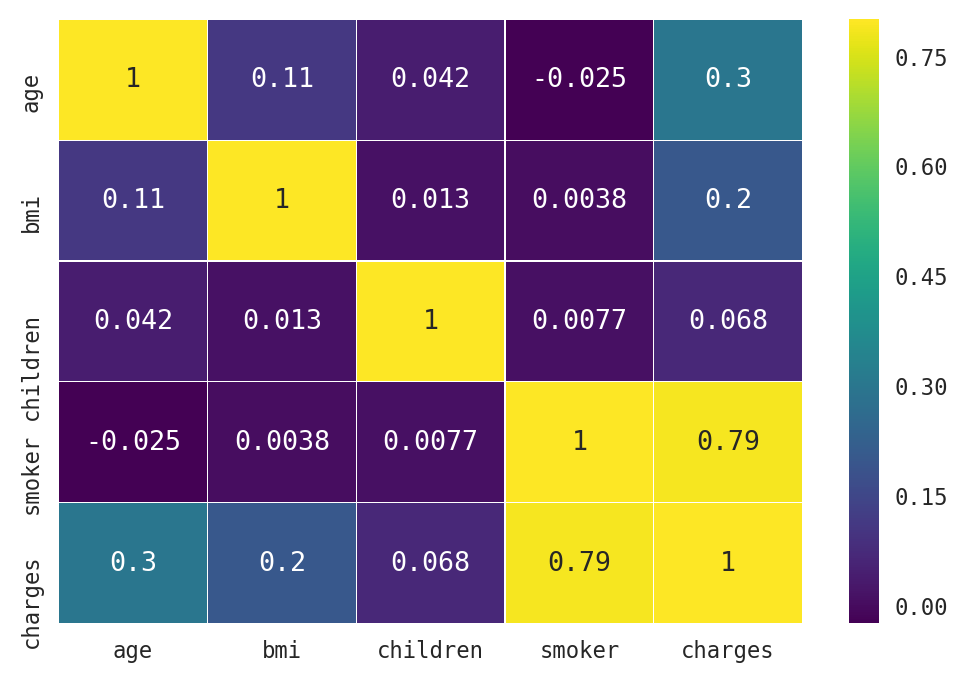

In [151]:
#Heat Map to see the correlation between diffrent variables
#Find the correlation between the different varaibles in the datasets
plt.figure(dpi=200)
cormat = df.corr()

#Draw the heatmap using seaborn
colormap = plt.cm.viridis
sns.heatmap(cormat, linewidths=0.1, cmap = colormap, linecolor = 'White', vmax=0.8, annot=True,)

We now have our important features only, and everything is numeric, we are ready to investigate each of the columns of the cleaned dataframe

At this point, we are ready to seperate our data into our **Feature Matrix "X"** and our **Target Vector "y"**

In [152]:
X = df.drop('charges',axis=1)
y = df.charges

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# **Insurance Charges**: The Dependent Variable (**Target Vector "y"**) we are interested in

Text(0.5,1,'Probability Density Estimate of Dependent Variable: Charges')

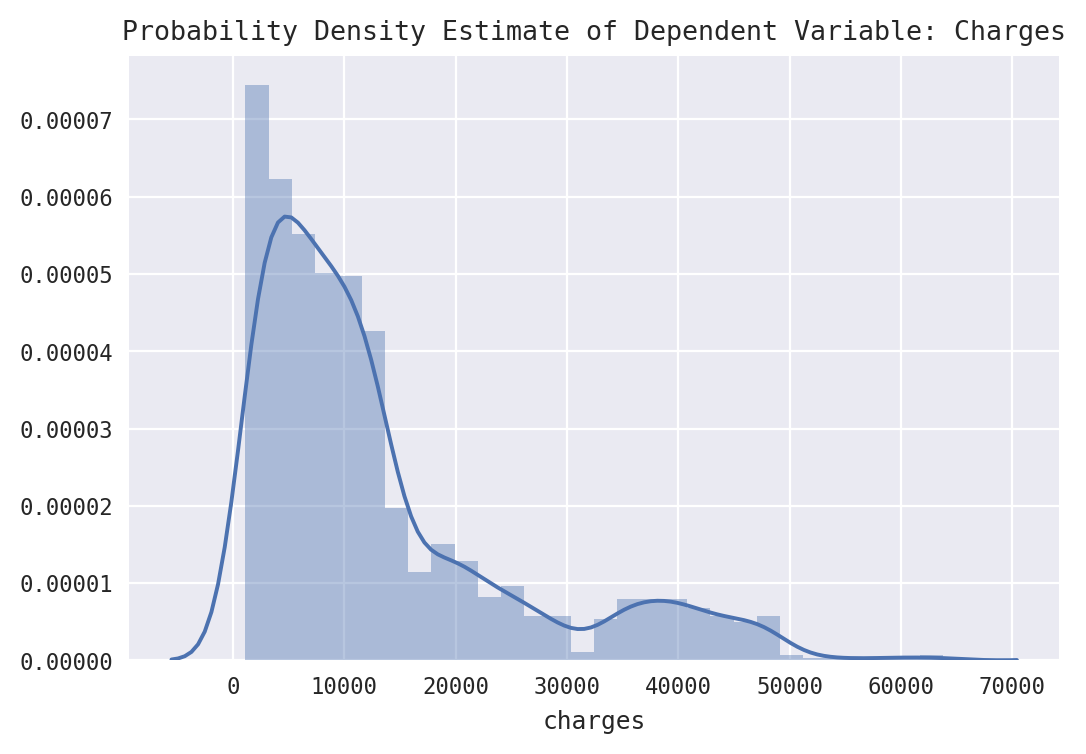

In [80]:
plt.figure(dpi=200)
sns.distplot(y)
plt.title('Probability Density Estimate of Dependent Variable: Charges')

Text(0.5,1,'Box plot of the target ("Insurance Charges")')

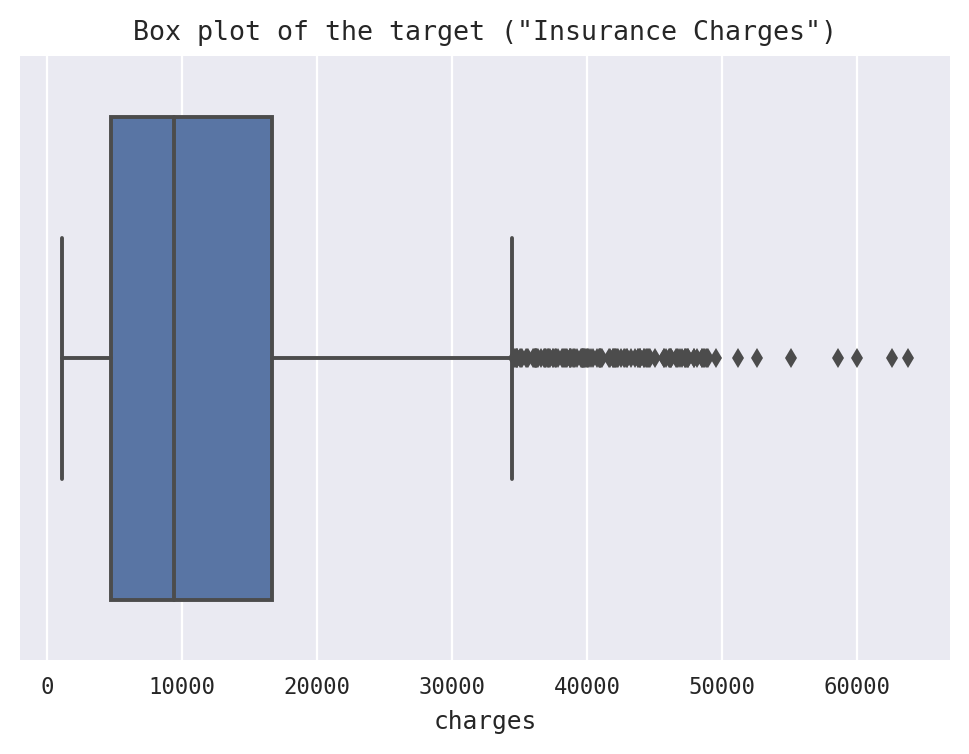

In [82]:
plt.figure(dpi=200)
sns.boxplot(y)
plt.title('Box plot of the target ("Insurance Charges")')

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# **Exploratory Data Analysis** of our independent (predictor) variables (**Feature Matrix "X"**)

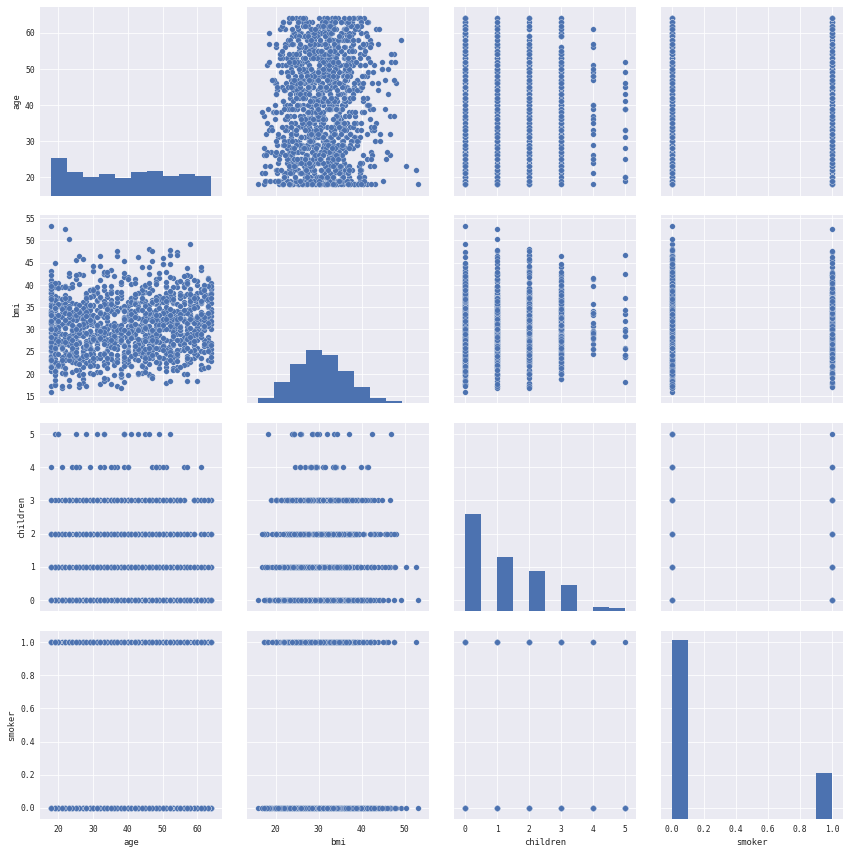

In [93]:
sns.pairplot(X,size=3)

# Investigation of Age

In [258]:
print('min age: {}'.format(df.age.min()))
print('max age: {}'.format(df.age.max()))

min age: 18
max age: 64


So, our dataset has insurance customers between the ages of 18 and 64, but it appears that we have significantly more 18 and 19 year olds

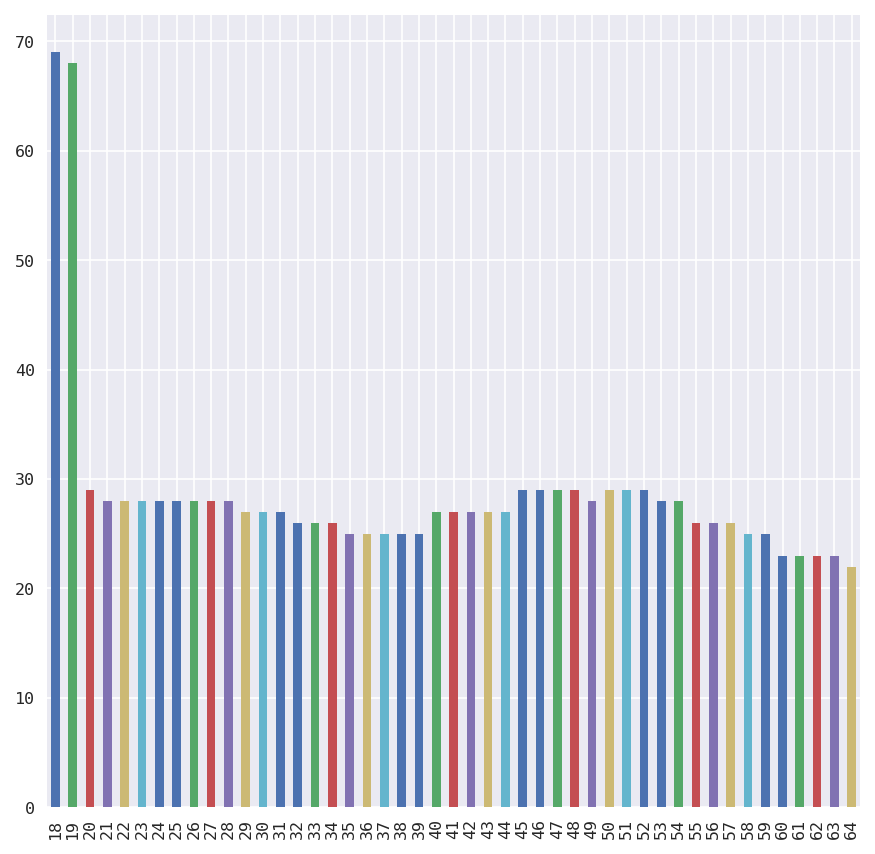

In [259]:
plt.figure(figsize=(7,7),dpi=150)
df.age.value_counts(sort=False).plot.bar()

What if we instead look at average insurance charges grouped by age, do we see a trend?

Text(0.5,1,'Average Insurance Charges vs Age')

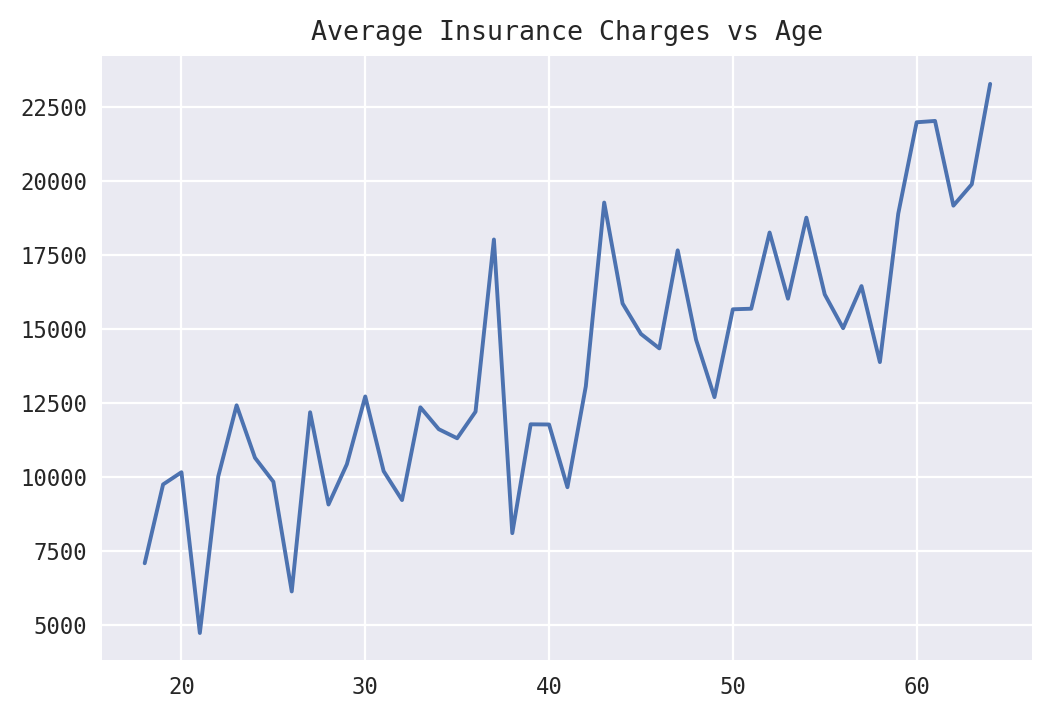

In [277]:
plt.figure(dpi=200)
ages = df.groupby('age')['charges'].mean().index
avg_charges = df.groupby('age')['charges'].mean().values
plt.plot(ages, avg_charges)
plt.title("Average Insurance Charges vs Age")

Let's look at how insurance charges vary with respect to age, we can fit a univariate linear regression model

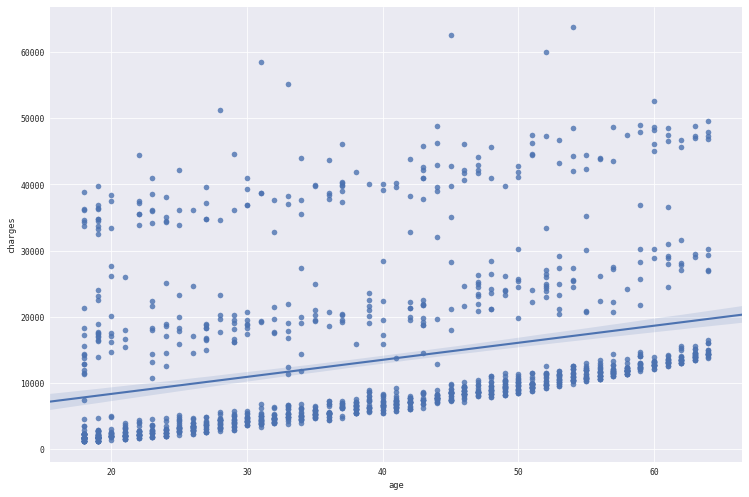

In [278]:
plt.figure(dpi=200)
sns.lmplot('age','charges', data=df,size=7, aspect = 1.5);

It appears that there is a positive correlation between age and insurance charges, which makes sense, but it also looks like there are two (or three?) sub-groups within this scatter plot

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Investigation of Smoking

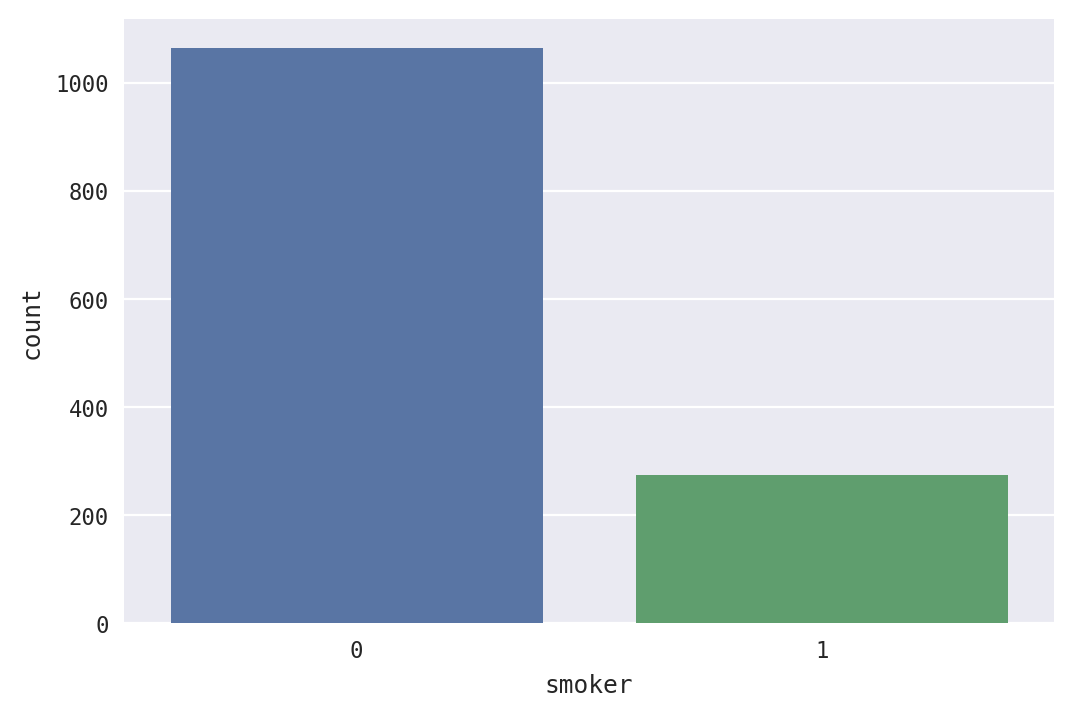

In [100]:
plt.figure(dpi=200)
sns.countplot(df['smoker'])

 Let's look at the average charges, grouped by whether a customer smokes or not

In [94]:
df.groupby(['smoker']).mean()['charges']

smoker
0     8434.268298
1    32050.231832
Name: charges, dtype: float64

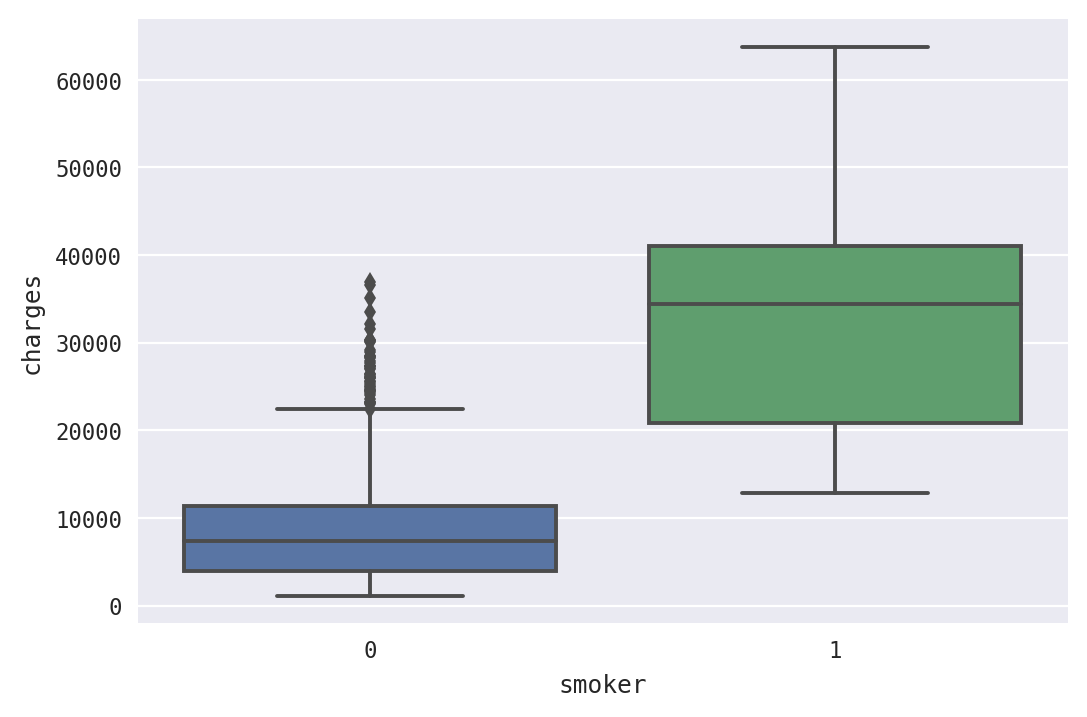

In [105]:
plt.figure(dpi=200)
sns.boxplot(x = "smoker", y = "charges", data = df)

In [106]:
plt.figure(dpi=200)
sns.distplot(df.charges,hue=df.smoker)

TypeError: distplot() got an unexpected keyword argument 'hue'

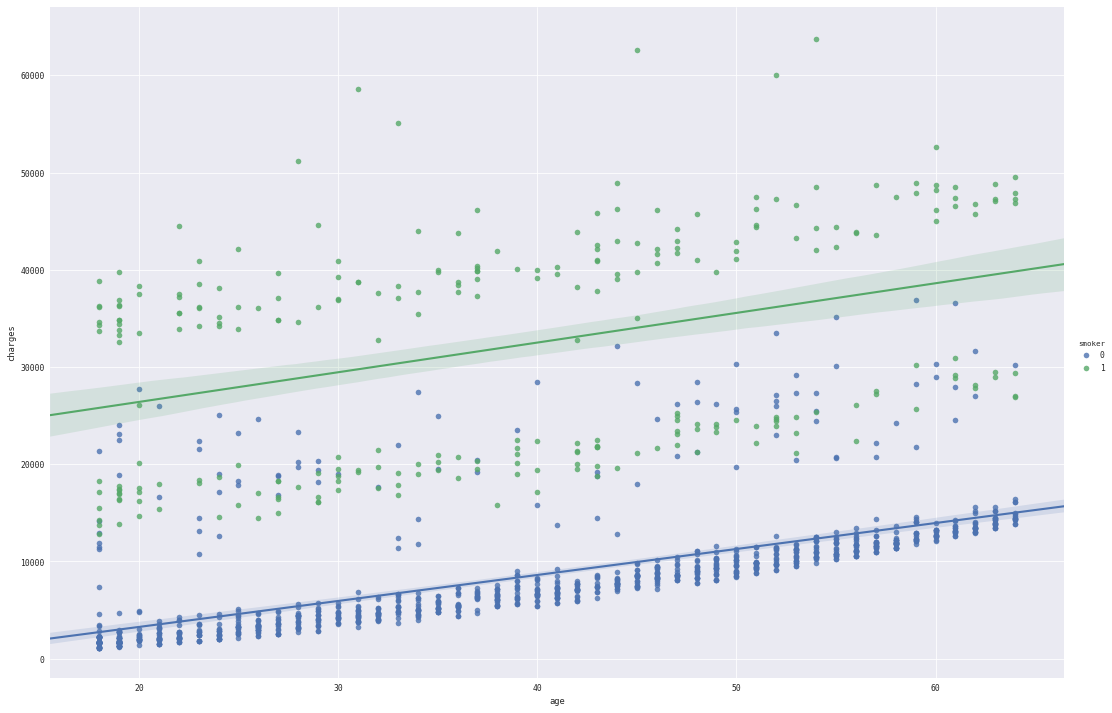

In [95]:
plt.figure(dpi=200)
sns.lmplot('age','charges',data=df,size=10,hue='smoker',aspect=1.5);

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Investigation of Body Mass Index (BMI)

### **Body Mass Index**, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg/m^2) using the ratio of height to weight, ideally 18.5 to 24.9

Text(0.5,1,'Probability Density Estimate of Body Mass Index')

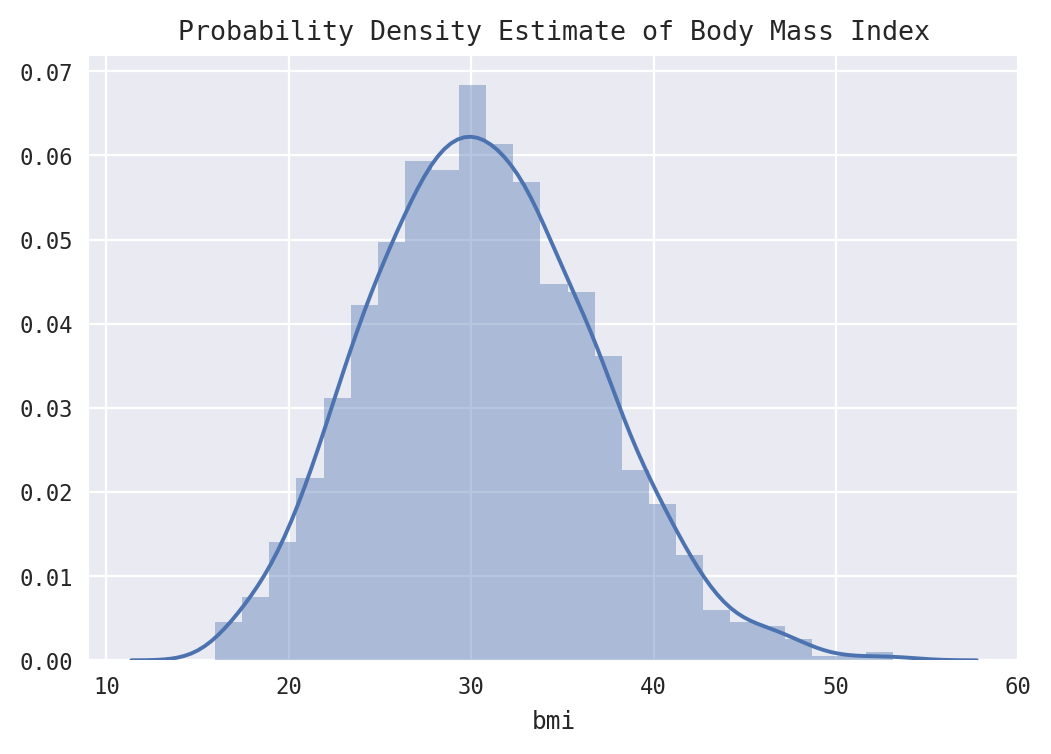

In [98]:
plt.figure(dpi=200)
sns.distplot(df.bmi)
plt.title('Probability Density Estimate of Body Mass Index')

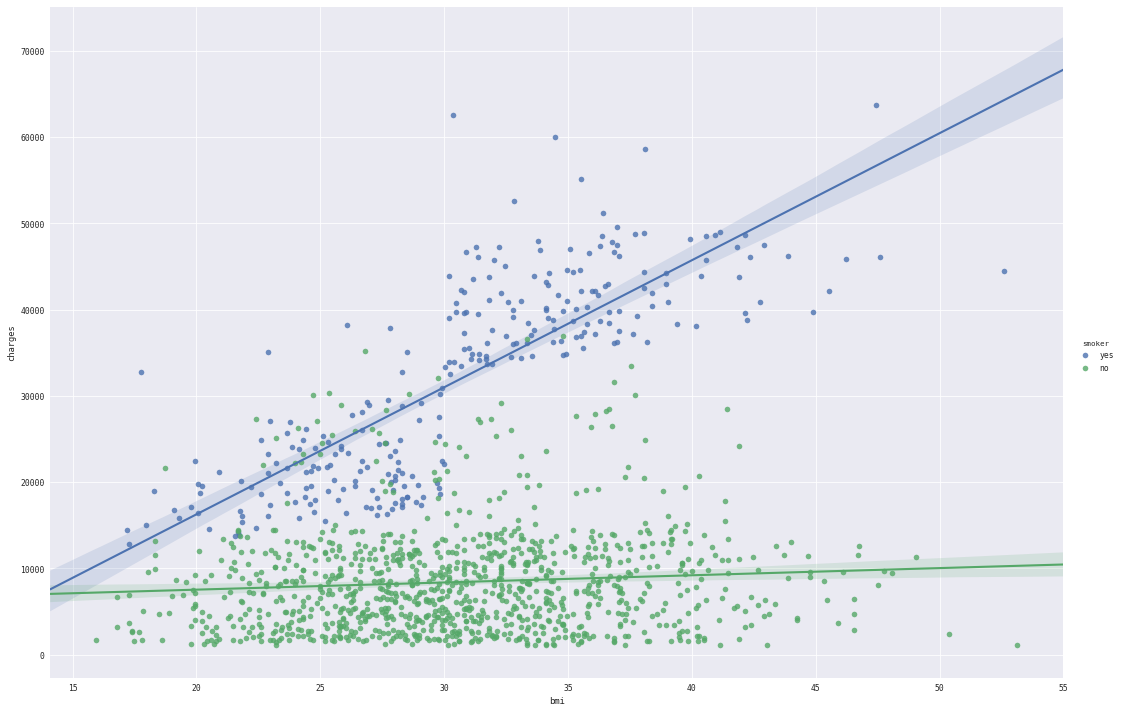

In [163]:
sns.lmplot('bmi', 'charges', data=df, size=10,hue='smoker',aspect=1.5);

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### **Children** the number covered by health insurance, a.k.a. the "number of dependents"

In [201]:
df.children.value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

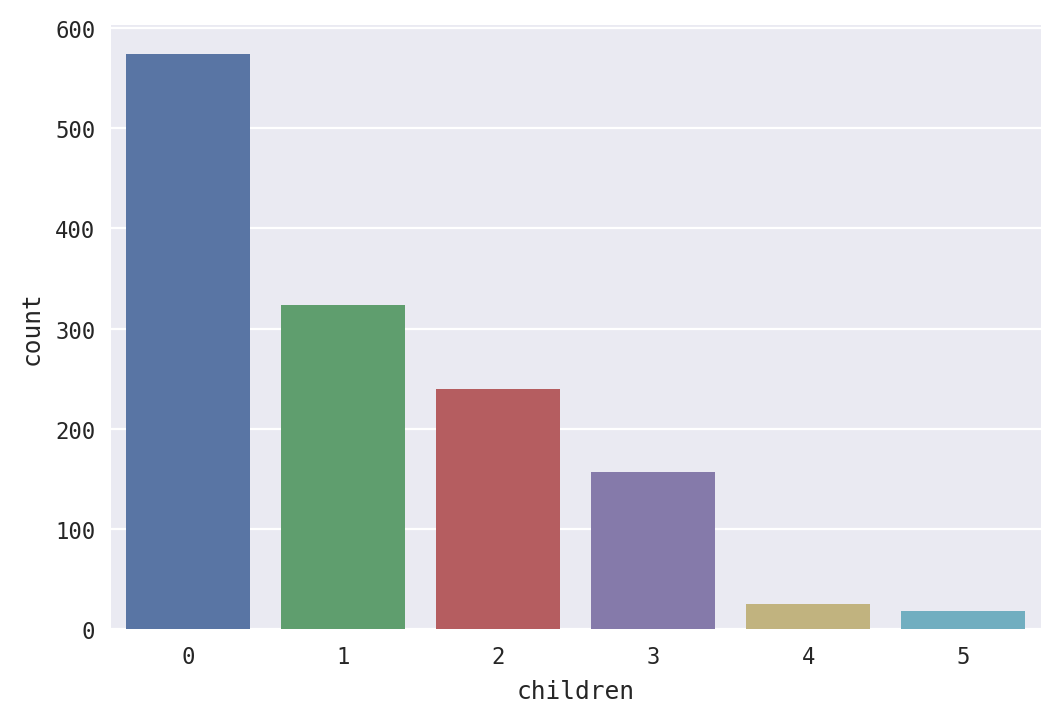

In [209]:
plt.figure(dpi=200)
sns.countplot(df.children)

Text(0.5,0,'Average Insurance Charges')

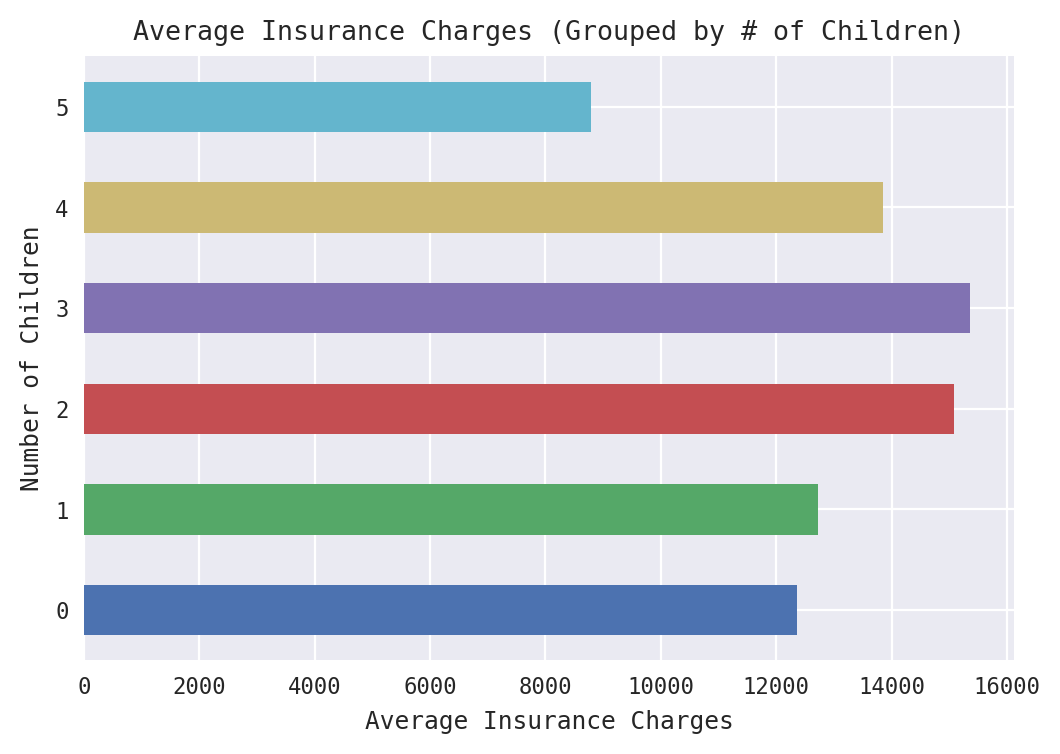

In [208]:
plt.figure(dpi=200)
df.groupby(['children']).mean()['charges'].plot.barh()
plt.title('Average Insurance Charges (Grouped by # of Children)')
plt.ylabel('Number of Children')
plt.xlabel('Average Insurance Charges')

In [124]:
X.head()

,age,bmi,children,smoker
0,19,27.900,0,1
1,18,33.770,1,0
2,28,33.000,3,0
3,33,22.705,0,0
4,32,28.880,0,0


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Standardize our Feature Matrix ("X")

In [128]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler()
X_train = X_std.fit_transform(X_train)
X_test = X_std.transform(X_test)

In [132]:
X_train = X_train

array([[-0.51485346, -0.18133104, -0.06360657, -0.50373604],
       [ 1.54874618, -1.39313042, -0.89214407, -0.50373604],
       [-1.43991536, -0.98224215, -0.06360657, -0.50373604],
       ...,
       [ 0.05441541, -0.9052006 , -0.89214407, -0.50373604],
       [-1.43991536,  0.77205813, -0.89214407, -0.50373604],
       [-0.44369485, -1.96131184, -0.06360657, -0.50373604]])

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Split our data into **TRAINING (X_train, y_train)** and **TESTING (X_test, y_test)** sets

In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [119]:
import statsmodels.api as sm
from scipy import stats

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [120]:
X_train2 = sm.add_constant(X_train)
linearModel = sm.OLS(y_train, X_train)
linear = linearModel.fit()
print(linear.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     1618.
Date:                Wed, 18 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:45:27   Log-Likelihood:                -10232.
No. Observations:                1003   AIC:                         2.047e+04
Df Residuals:                     999   BIC:                         2.049e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          192.2557     13.577     14.160      0.0

# MCMC

In [ ]:
beta0 = pm.Normal("beta0", 0, 0.0001)
noise = pm.Uniform("noise", 0, 500)

In [ ]:
b = np.empty(5, dtype=object)
x = np.empty(5, dtype=object)

In [ ]:
b1 = pm.Normal("b1", 0, 0.0001); b[1] = b1
b2 = pm.Normal("b2", 0, 0.0001); b[2] = b2
b3 = pm.Normal("b3", 0, 0.0001); b[3] = b3
b4 = pm.Normal("b4", 0, 0.0001); b[4] = b4

In [ ]:
x1 = pm.Normal("x1", 0, 1, df['smoker'], observed=True)
x[1] = x1
x2 = pm.Normal("x2", 0, 1, df['bmi'], observed=True)
x[2] = x2
x3 = pm.Normal("x3", 0, 1, df['age'], observed=True)
x[3] = x3
x4 = pm.Normal("x4", 0, 1, df['children'], observed=True)
x[4] = x4

In [ ]:
@pm.deterministic
def pred(beta0 = beta0, b = b, x = x):
    return beta0 + b[1]*x[2] + b[2]*x[2] + b[3]*x[3] + b[4]*x[4]

In [ ]:
y = pm.Normal("y", pred, noise, value = np.array(df['charges']), observed = True)

model = pm.Model([beta0, pm.Container(b), noise, pm.Container(x), y, pred])

In [ ]:
import pydot
import pymc.graph
from IPython.display import display_png

In [ ]:
graph = pm.graph.graph(model)
display_png(graph.create_png(), raw = True)

In [ ]:
mcmc = pm.MCMC(model)
mcmc.sample(100000, 200)

In [ ]:
mcmc.trace()

In [ ]:
#multifig, multiax = plt.subplots(2, 1, figsize=(10, 10))
b0_val = np.mean(mcmc.trace('beta0')[:])
plt.hist(mcmc.trace('b1')[:], bins=100)

b1_val = np.mean(mcmc.trace('b1')[:])
plt.hist(mcmc.trace('b1')[:], bins=100)

b4_val = np.mean(mcmc.trace('b4')[:])
plt.hist(mcmc.trace('b4')[:], bins=100)

b3_val = np.mean(mcmc.trace('b3')[:])
plt.hist(mcmc.trace('b3')[:], bins=100)

b2_val = np.mean(mcmc.trace('b2')[:])
plt.hist(mcmc.trace('b2')[:], bins=100)

plt.show()

In [ ]:
print("B0: " + str(np.mean(b0_val)))
print("B1: " + str(np.mean(b1_val)))
print("B2: " + str(np.mean(b2_val)))
print("B3: " + str(np.mean(b3_val)))
print("B4: " + str(np.mean(b4_val)))

In [ ]:
import numpy as np
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_bmi, y)
prediction_space = np.linspace(min(X_bmi), max(X_bmi)).reshape(-1, 1)
plt.scatter(X_bmi, y, color = "blue")
plt.plot(prediction_space ,reg.predict(prediction_space), color = "black", 
         linewidth=3)
plt.show()

In [ ]:
## BMI
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bmi, y, test_size = 0.3, 
                                                   random_state = 42)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

In [ ]:
## BMI + AGE
X_bmi_age = df[['bmi','age']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bmi_age, y, test_size = 0.3, 
                                                   random_state = 42)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

In [ ]:
## Bmi + Age + Children
X_bmi_age_child = df[['bmi', 'age', 'children']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bmi_age_child, y, test_size = 0.3, 
                                                   random_state = 42)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

In [ ]:
# Bmi + Age + Smoke
X_bmi_age_child = df[['bmi', 'age', 'smoker_no','smoker_yes']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bmi_age_child, y, test_size = 0.3, 
                                                   random_state = 42)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

In [ ]:
# All the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

In [ ]:
def linear_regression(X, y, m_current=0, b_current=0, epochs=1000, learning_rate=0.0001):
    N = float(len(y))
    for i in range(epochs):
        y_current = (m_current * X) + b_current
        cost = sum([data**2 for data in (y-y_current)]) / N
        m_gradient = -(2/N) * sum(X * (y - y_current))
        b_gradient = -(2/N) * sum(y - y_current)
        m_current = m_current - (learning_rate * m_gradient)
        b_current = b_current - (learning_rate * b_gradient)
    return m_current, b_current, cost

In [ ]:
linear_regression(X_bmi, y)